In [133]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
from torchvision import datasets, transforms
from IPython.display import display, HTML
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

DATA = {
    'train': 'drive/My Drive/KAGGLE/titanic/train.csv',
    'test': 'drive/My Drive/KAGGLE/titanic/test.csv'
}
CUDA_LAUNCH_BLOCKING=1.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [118]:
train = pd.read_csv(DATA['train'])
test = pd.read_csv(DATA['test'])
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [119]:
train.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Coleridge, Mr. Reginald Charles",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [120]:
train.isnull().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [121]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())
train.info()
# test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [122]:
Y = train.iloc[:, 1]
X = train.drop(["Survived","Name","Ticket","PassengerId","Embarked","Cabin"], axis = 1)

X_label = test['PassengerId']
X_test = test.drop(["Name","Ticket","PassengerId","Embarked","Cabin"], axis = 1)

In [123]:
X.replace({'Sex':{'male': 1, 'female': 0}}, inplace= True)
X_test.replace({'Sex': {'male': 1, 'female': 0}}, inplace = True)
# display(HTML(X.to_html()))
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    int64  
 1   Sex     891 non-null    int64  
 2   Age     891 non-null    float64
 3   SibSp   891 non-null    int64  
 4   Parch   891 non-null    int64  
 5   Fare    891 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 41.9 KB


In [124]:
NUM_PASSENGER = len(Y)
BATCH_SIZE = NUM_PASSENGER
print("Number of passengers: {}".format(NUM_PASSENGER))

Number of passengers: 891


In [125]:
def normalize_data(X):
    mean = np.mean(X,axis=0)                    #Mean of row
    std = np.std(X,axis=0)                      #Std of row
    X[:,1:] = (X[:,1:]-mean[1:])/std[1:]
    return X

In [126]:
#Make polynomial Features
def make_feature(X, poly=2):
    poly = PolynomialFeatures(poly)
    X_poly = poly.fit_transform(X)
    #print(X.shape)
    #print(X_poly.shape)
    return X_poly

In [127]:
X = np.array(X).reshape(X.shape[0], -1).astype(np.float32) #Convert into numpy array
Y = np.array(Y).reshape(-1,1)
X = make_feature(X,2)
X = normalize_data(X)

X_test = np.array(X_test).reshape(X_test.shape[0], -1).astype(np.float32)
X_label = np.array(X_label).reshape(-1, 1)
X_test = make_feature(X_test, 2)
X_test = normalize_data(X_test)

In [128]:
NUM_PARAMETER = len(X[0])
print(NUM_PARAMETER)

28


In [108]:
class LogisticRegression(nn.Module):
    def __init__(self, inp):
        super(LogisticRegression, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(inp,10),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(10,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)

In [109]:
def training_step(model, optimizer, error, trainloader):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for (target, label) in trainloader:
        model.zero_grad()
        target = Variable(target).view(-1,NUM_PARAMETER).to(device)
        label = Variable(label).view(-1,1).to(device)

        outputs = model(target)
        
        prediction = 1 if outputs.data > 0.5 else 0

        loss = error(outputs, label.float())
        
        loss.backward()
        optimizer.step()
        train_loss += loss.data
        total += len(target)
        correct += (prediction == label).sum()
    acc = correct*1.0/total
    return train_loss, acc

In [110]:
def evaluating_step(model, optimizer, error, valloader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for (target, label) in valloader:
            target = Variable(target).view(-1,NUM_PARAMETER).to(device)
            label = Variable(label).view(-1,1).to(device)
            
            outputs = model(target)
            prediction = 1 if outputs.data > 0.5 else 0
            loss = error(outputs, label.float())
            val_loss += loss.data
            total += len(target)
            correct += (prediction == label).sum()
        acc = correct*1.0/total
    return val_loss, acc

In [111]:
def plot(train_loss_list, train_acc_list, val_loss_list, val_acc_list, EPOCHS):
    fig = plt.figure(figsize=(20,5))
    fig.add_subplot(1,2,1)
    plt.plot(range(EPOCHS),train_loss_list, color = 'green', label = "Train Loss")
    plt.plot(range(EPOCHS),val_loss_list, color = "blue", label = "Val Loss")
    plt.legend()
    fig.add_subplot(1,2,2)
    plt.plot(range(EPOCHS),train_acc_list, color = 'green', label = "Train Accuracy")
    plt.plot(range(EPOCHS),val_acc_list, color = "blue", label = "Val Accuracy")
    plt.legend()
    plt.show()

In [112]:
def train(EPOCHS, model, optimizer, error, trainloader, valloader):
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in range(EPOCHS):
        train_loss, train_acc = training_step(model,optimizer, error, trainloader)
        val_loss, val_acc = evaluating_step(model,optimizer, error, valloader)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        print("Epoch: ({}/{}), Train loss: {:3f}, Train Acc: {:3f}, Val loss: {:3f}, Val Acc: {:3f}".format(epoch+1,EPOCHS, train_loss,
                                                                                                train_acc, val_loss, val_acc))
    return model, train_loss_list, train_acc_list, val_loss_list, val_acc_list

Start training at fold: 1...
Epoch: (1/30), Train loss: 480.639832, Train Acc: 0.577247, Val loss: 116.717613, Val Acc: 0.743017
Epoch: (2/30), Train loss: 452.585144, Train Acc: 0.681180, Val loss: 104.276375, Val Acc: 0.787709
Epoch: (3/30), Train loss: 413.244843, Train Acc: 0.731742, Val loss: 97.160561, Val Acc: 0.804469
Epoch: (4/30), Train loss: 407.768524, Train Acc: 0.716292, Val loss: 93.012413, Val Acc: 0.798883
Epoch: (5/30), Train loss: 391.610046, Train Acc: 0.764045, Val loss: 90.381409, Val Acc: 0.782123
Epoch: (6/30), Train loss: 378.340881, Train Acc: 0.747191, Val loss: 88.443001, Val Acc: 0.793296
Epoch: (7/30), Train loss: 367.688293, Train Acc: 0.778090, Val loss: 86.903191, Val Acc: 0.798883
Epoch: (8/30), Train loss: 363.032776, Train Acc: 0.762640, Val loss: 85.914635, Val Acc: 0.815642
Epoch: (9/30), Train loss: 359.200836, Train Acc: 0.775281, Val loss: 85.652748, Val Acc: 0.810056
Epoch: (10/30), Train loss: 357.572510, Train Acc: 0.759831, Val loss: 84.9941

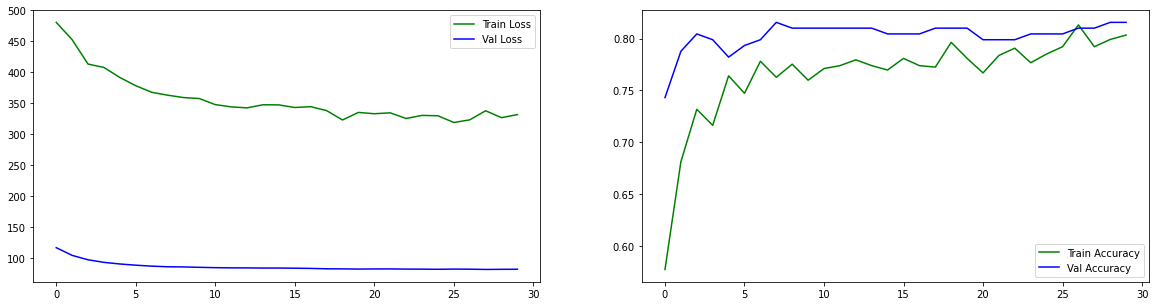

Start training at fold: 2...
Epoch: (1/30), Train loss: 452.060883, Train Acc: 0.656381, Val loss: 110.891228, Val Acc: 0.679775
Epoch: (2/30), Train loss: 423.146820, Train Acc: 0.695652, Val loss: 101.879478, Val Acc: 0.797753
Epoch: (3/30), Train loss: 396.851654, Train Acc: 0.722300, Val loss: 95.618568, Val Acc: 0.814607
Epoch: (4/30), Train loss: 378.431305, Train Acc: 0.765778, Val loss: 90.597519, Val Acc: 0.820225
Epoch: (5/30), Train loss: 360.937286, Train Acc: 0.776999, Val loss: 87.304207, Val Acc: 0.814607
Epoch: (6/30), Train loss: 363.040405, Train Acc: 0.775596, Val loss: 85.304138, Val Acc: 0.808989
Epoch: (7/30), Train loss: 350.872223, Train Acc: 0.788219, Val loss: 83.505142, Val Acc: 0.808989
Epoch: (8/30), Train loss: 345.427765, Train Acc: 0.788219, Val loss: 82.243622, Val Acc: 0.808989
Epoch: (9/30), Train loss: 342.703735, Train Acc: 0.778401, Val loss: 81.705849, Val Acc: 0.808989
Epoch: (10/30), Train loss: 340.818909, Train Acc: 0.788219, Val loss: 81.1407

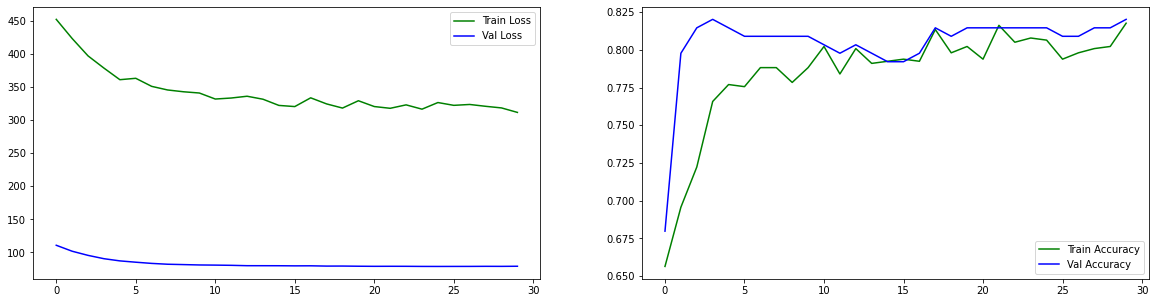

Start training at fold: 3...
Epoch: (1/30), Train loss: 505.081451, Train Acc: 0.493689, Val loss: 117.529968, Val Acc: 0.696629
Epoch: (2/30), Train loss: 450.433044, Train Acc: 0.645161, Val loss: 104.816109, Val Acc: 0.786517
Epoch: (3/30), Train loss: 406.500946, Train Acc: 0.729313, Val loss: 96.217018, Val Acc: 0.786517
Epoch: (4/30), Train loss: 379.988007, Train Acc: 0.768583, Val loss: 90.527191, Val Acc: 0.792135
Epoch: (5/30), Train loss: 374.204895, Train Acc: 0.755961, Val loss: 87.976616, Val Acc: 0.786517
Epoch: (6/30), Train loss: 353.723785, Train Acc: 0.779804, Val loss: 85.747963, Val Acc: 0.786517
Epoch: (7/30), Train loss: 358.095886, Train Acc: 0.781206, Val loss: 84.454826, Val Acc: 0.792135
Epoch: (8/30), Train loss: 361.820221, Train Acc: 0.765778, Val loss: 83.912613, Val Acc: 0.786517
Epoch: (9/30), Train loss: 355.254486, Train Acc: 0.768583, Val loss: 83.206635, Val Acc: 0.786517
Epoch: (10/30), Train loss: 335.623199, Train Acc: 0.792426, Val loss: 82.4541

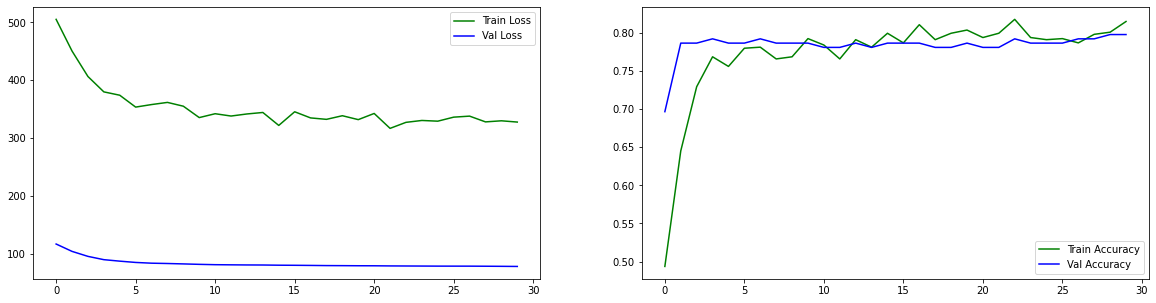

Start training at fold: 4...
Epoch: (1/30), Train loss: 472.273651, Train Acc: 0.638149, Val loss: 113.482613, Val Acc: 0.657303
Epoch: (2/30), Train loss: 431.691650, Train Acc: 0.737728, Val loss: 106.284615, Val Acc: 0.741573
Epoch: (3/30), Train loss: 404.401001, Train Acc: 0.768583, Val loss: 100.060692, Val Acc: 0.741573
Epoch: (4/30), Train loss: 386.235229, Train Acc: 0.784011, Val loss: 95.795792, Val Acc: 0.735955
Epoch: (5/30), Train loss: 381.949188, Train Acc: 0.795231, Val loss: 92.347252, Val Acc: 0.758427
Epoch: (6/30), Train loss: 371.249756, Train Acc: 0.809257, Val loss: 90.114281, Val Acc: 0.758427
Epoch: (7/30), Train loss: 355.430634, Train Acc: 0.812062, Val loss: 88.841499, Val Acc: 0.769663
Epoch: (8/30), Train loss: 361.577484, Train Acc: 0.795231, Val loss: 87.904984, Val Acc: 0.769663
Epoch: (9/30), Train loss: 360.207458, Train Acc: 0.803647, Val loss: 87.331238, Val Acc: 0.769663
Epoch: (10/30), Train loss: 343.378510, Train Acc: 0.812062, Val loss: 86.506

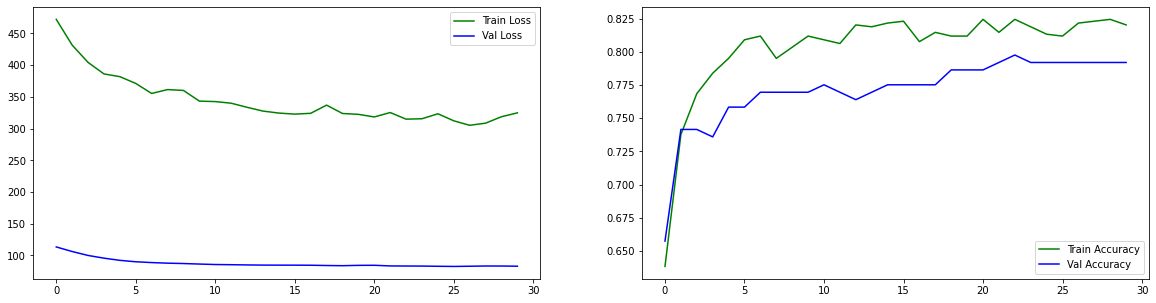

Start training at fold: 5...
Epoch: (1/30), Train loss: 460.892242, Train Acc: 0.660589, Val loss: 104.606705, Val Acc: 0.837079
Epoch: (2/30), Train loss: 420.000305, Train Acc: 0.741935, Val loss: 95.092491, Val Acc: 0.820225
Epoch: (3/30), Train loss: 395.955078, Train Acc: 0.762973, Val loss: 88.000145, Val Acc: 0.820225
Epoch: (4/30), Train loss: 380.280365, Train Acc: 0.761571, Val loss: 82.537231, Val Acc: 0.820225
Epoch: (5/30), Train loss: 370.940521, Train Acc: 0.774194, Val loss: 78.970825, Val Acc: 0.820225
Epoch: (6/30), Train loss: 363.909943, Train Acc: 0.776999, Val loss: 76.392845, Val Acc: 0.837079
Epoch: (7/30), Train loss: 364.304993, Train Acc: 0.795231, Val loss: 74.929977, Val Acc: 0.820225
Epoch: (8/30), Train loss: 354.655670, Train Acc: 0.778401, Val loss: 73.549980, Val Acc: 0.853933
Epoch: (9/30), Train loss: 357.574615, Train Acc: 0.774194, Val loss: 72.533340, Val Acc: 0.853933
Epoch: (10/30), Train loss: 358.083710, Train Acc: 0.778401, Val loss: 71.81940

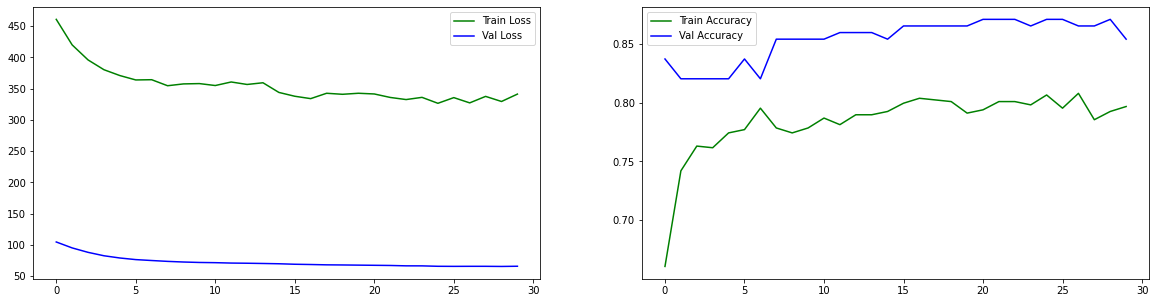

Best fold: 5


In [113]:
best_model = LogisticRegression(NUM_PARAMETER).to(device)
TRAIN_DATA = 1
if TRAIN_DATA:
    EPOCHS = 30
    best_val_acc = 0
    best_fold = 0
    kf = KFold()
    for fold, (train_id, val_id) in enumerate(kf.split(X)):
        X_train , X_val = X[train_id], X[val_id]
        y_train, y_val = Y[train_id], Y[val_id]
        
        trainset = data.TensorDataset(torch.from_numpy(X_train), torch.LongTensor(torch.from_numpy(y_train)))
        valset = data.TensorDataset(torch.from_numpy(X_val), torch.LongTensor(torch.from_numpy(y_val)))
        
        trainloader = data.DataLoader(trainset, num_workers= 4, batch_size=1)
        valloader = data.DataLoader(valset, num_workers= 4, batch_size=1)
        
        model = LogisticRegression(NUM_PARAMETER).to(device)
        error = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr= 0.0002, weight_decay = 1e-5)
        print("Start training at fold: {}...".format(fold+1))
        model, train_loss_list, train_acc_list, val_loss_list, val_acc_list = train(EPOCHS,model,optimizer,error,trainloader,valloader)
        print("Fold {} completed! Plotting...".format(fold+1))
        plot(train_loss_list, train_acc_list, val_loss_list, val_acc_list, EPOCHS)
        if val_acc_list[-1] > best_val_acc:
            best_val_acc = val_acc_list[-1]
            torch.save(model.state_dict(), f"drive/My Drive/KAGGLE/titanic/checkpoint/best_fold_{best_fold}.pt")
            best_model = model
            best_fold = fold+1
    
    print("Best fold: {}".format(best_fold))

In [131]:
def predict(model, X):
    model.eval()
    preds = []
    with torch.no_grad():
        X = Variable(torch.from_numpy(X)).view(-1, NUM_PARAMETER).to(device)
        outputs = model(X)
        preds = [1 if pred > 0.5 else 0 for pred in outputs.data]
    
    return preds

In [134]:
best_model.load_state_dict(torch.load(f"drive/My Drive/KAGGLE/titanic/checkpoint/best_fold_2.pt"))
result = predict(best_model, X_test)
with open('output.csv', 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(['PassengerID', 'Survived'])
    for i, j in tqdm(zip(X_label, result)):
        writer.writerow([i, j])

418it [00:00, 16623.86it/s]
